In [44]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

In [45]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()  # 将IMG转化为Tensor
mnist_train = torchvision.datasets.FashionMNIST(
    root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="./data", train=False, transform=trans, download=True)

In [46]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [12]:
mnist_train[0][0].shape  # 第0个图片，通道数为1（黑白），长、宽分别为28像素

torch.Size([1, 28, 28])

In [20]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


get_fashion_mnist_labels([0, 1])

['t-shirt', 'trouser']

In [21]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

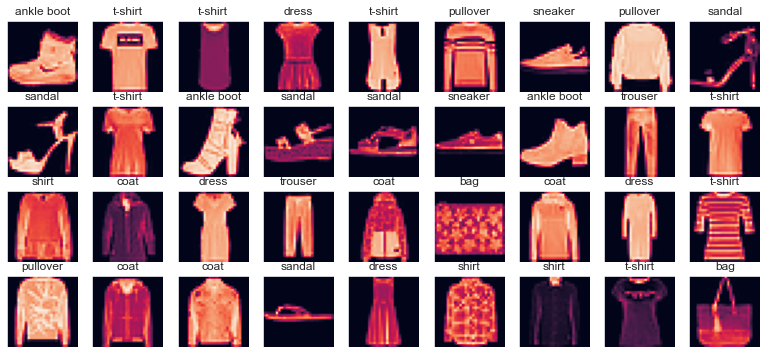

In [55]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=36)))
show_images(X.reshape(36, 28, 28), 4, 9, titles=get_fashion_mnist_labels(y));

In [57]:
batch_size = 256


def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 2


train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [107]:
timer = d2l.Timer()
for X, y in train_iter:
    print(X.reshape((-1, W.shape[0])).shape)
    break
    # continue
f'{timer.stop():.2f} sec'

torch.Size([256, 784])


'2.47 sec'

In [33]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

## 从零开始实现softmax

In [34]:
import torch
from IPython import display
from d2l import torch as d2l

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [63]:
num_inputs = 784  # 每个图片本来是28×28，拉伸成一个1×784的一维Tensor，然后再计算
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [62]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制


X = torch.arange(1, 10).view(-1, 3)
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0900, 0.2447, 0.6652],
         [0.0900, 0.2447, 0.6652],
         [0.0900, 0.2447, 0.6652]]),
 tensor([1., 1., 1.]))

In [64]:
def net(X):
    # W.shape[0]=256, 所以这里的X将会被reshape成一个784×256的矩阵
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [88]:
y = torch.tensor([2, 1, 1])
y_hat = torch.tensor([
    [0.1, 0.3, 0.6],
    [0.3, 0.2, 0.5],
    [0.1, 0.8, 0.1],
])
y_hat[range(len(y_hat)), y]

tensor([0.6000, 0.2000, 0.8000])

In [89]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])


cross_entropy(y_hat, y)

tensor([0.5108, 1.6094, 0.2231])

In [91]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:  # 如果y_hat为一个矩阵
        y_hat = y_hat.argmax(axis=1)  # 取出y_hat中最大概率的index
        # print(y_hat)
    cmp = y_hat.type(y.dtype) == y  # cmp反应的是y_hat中的最大概率是不是y中的标签
    print(cmp.type(y.dtype))
    return float(cmp.type(y.dtype).sum())  # 返回的结果其实就是预测对了几个


accuracy(y_hat, y) / len(y)

tensor([1, 0, 1])


0.6666666666666666

In [97]:
class Accumulator:  #@save
    """在n个变量上累加"""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        print(self.data)

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


demo = Accumulator(2)
demo.add(2, 10)
demo[0], demo[1]

[2.0, 10.0]


(2.0, 10.0)

In [102]:
a = [1, 2]
b = [2, 4]

[str(i) + '-' + str(j) for i, j in zip(a, b)]

['1-2', '2-4']

In [ ]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())  # 计算正确的数量、样本总数
    return metric[0] / metric[1]



In [103]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]